In [56]:
import os
import sys
import scipy.io
import scipy.misc
import pprint
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from PIL import Image
from matplotlib.pyplot import imshow
from utils import *

%matplotlib inline
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(0)

In [57]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False, input_shape=(img_size,img_size,3),weights='models/vgg19_model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

<Functional name=vgg19, built=True>


### Cost Functions
Content Cost Function -> Style Cost Function (Gram Matrix) -> Complete Cost Function

In [96]:
def compute_content_cost(content_output, generated_output):

    aC = content_output[-1]
    aG = generated_output[-1]

    _, n_H, n_W, n_C = aG.get_shape().as_list()

    aC_unrolled = tf.reshape(aC, shape=[_, -1, n_C]) # 1 way
    aG_unrolled = tf.reshape(aG, shape=[_, n_H*n_W, n_C]) # the other way to do the same as above
    
    j_content = tf.multiply((1/(4*n_H*n_W*n_C)),tf.reduce_sum(tf.square(tf.subtract(aC_unrolled, aG_unrolled))))
    
    return j_content

In [97]:
compute_content_cost_test(compute_content_cost)

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)

Don't use the numpy API inside compute_content_cost

'KerasTensor' object has no attribute 'get_shape'


/home/alifseen/miniconda3/envs/ml3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [128]:
def gram_matrix(A):
    GA = tf.linalg.matmul(A, A, transpose_b=True)
    return GA

In [129]:
def compute_layer_style_cost(a_S, a_G):

    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(a_S, perm=[0,3,1,2])
    a_G = tf.transpose(a_G, perm=[0,3,1,2])
    
    a_S = tf.reshape(a_S, shape=[_, n_C, -1])
    a_G = tf.reshape(a_G, shape=[_,n_C, -1])

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    factor = 4 * (n_H * n_W)**2 * (n_C**2)
    J_style_layer = tf.reduce_sum(tf.square(GS - GG)) / factor
    
    return J_style_layer

In [132]:
# List down the layers of the network

for layer in vgg.layers:
    print(layer.name)

input_layer_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [133]:
# Check a layer
vgg.get_layer("block5_conv4").output

<KerasTensor shape=(None, 25, 25, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_54>

In [134]:
# Select starting layers that carry abstract low level information as style layers and assign weightage to them
styling_layers= [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [135]:
# Style cost is how similar a style is to the selected layers features
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS = styling_layers):
    J_style = 0

    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]

    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        J_style += weight[1] * J_style_layer

    return J_style

In [141]:
@tf.function()
def total_cost(content_cost, style_cost, alpha=10, beta=40):
    J = (alpha*content_cost)+(beta*style_cost)
    print(J)
    return J

### Inference

In [158]:
# Load Images
content_image = np.array(Image.open("datasets/style_transfer/louvre_small.jpg").resize((img_size, img_size)))
style_image =  np.array(Image.open("datasets/style_transfer/monet.jpg").resize((img_size, img_size)))

content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))


# Initialize Generated Image
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image.assign_add(noise)
generated_image.assign(tf.clip_by_value(generated_image, 0.0, 1.0))

<tf.Variable 'UnreadVariable' shape=(1, 400, 400, 3) dtype=float32, numpy=
array([[[[0.21543022, 0.05640045, 0.23659372],
         [0.        , 0.38830116, 0.5609467 ],
         [0.05642815, 0.2502747 , 0.2566719 ],
         ...,
         [0.01660641, 0.06895837, 0.2644029 ],
         [0.12333412, 0.        , 0.5867443 ],
         [0.        , 0.25128502, 0.5601982 ]],

        [[0.30792606, 0.22556165, 0.4550581 ],
         [0.16831185, 0.17442396, 0.69468844],
         [0.        , 0.08695588, 0.43818396],
         ...,
         [0.16946234, 0.        , 0.3783271 ],
         [0.1375903 , 0.04001345, 0.2373778 ],
         [0.        , 0.2643702 , 0.3116515 ]],

        [[0.3030163 , 0.01434007, 0.53952223],
         [0.34739482, 0.33065674, 0.56461203],
         [0.2774604 , 0.26118216, 0.5931157 ],
         ...,
         [0.        , 0.41512308, 0.3884627 ],
         [0.15138014, 0.24883594, 0.29588798],
         [0.        , 0.14710219, 0.15843192]],

        ...,

        [[0.15501

In [159]:
# Load Model
def get_layer_output(model, layer_names):
    outputs = [model.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([model.input], outputs)

    return model

In [160]:
# Get encoder
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_output(vgg, styling_layers+content_layer)

In [161]:
# Encode images
content_target = vgg_model_outputs(content_image)
style_targets = vgg_model_outputs(style_image)

In [162]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [163]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [164]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [165]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [170]:
@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
    
        J_style = compute_style_cost(a_S, a_G)
    
        J_content = compute_content_cost(a_C, a_G)

        J = total_cost(J_content, J_style)

    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    return J

Epoch 0 


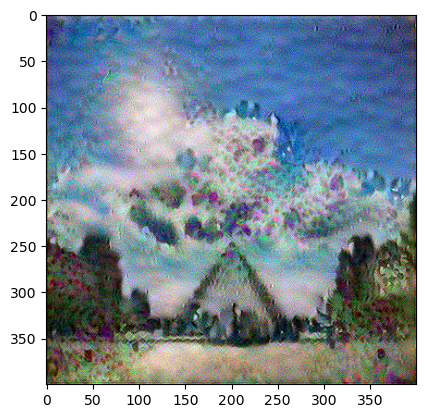

Epoch 250 


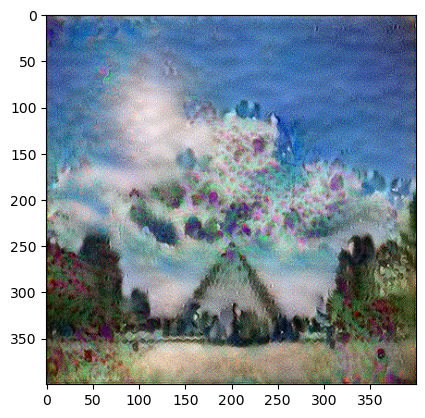

Epoch 500 


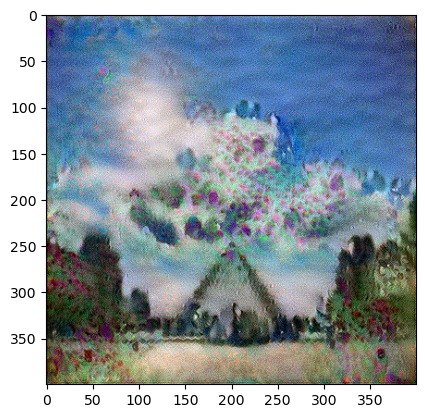

Epoch 750 


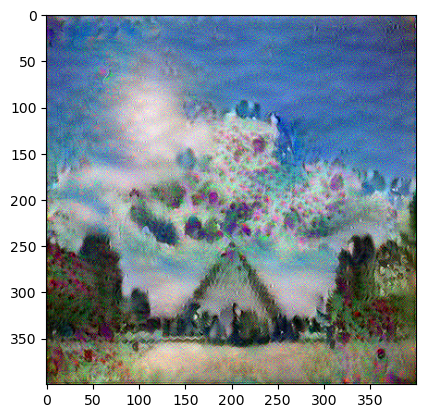

Epoch 1000 


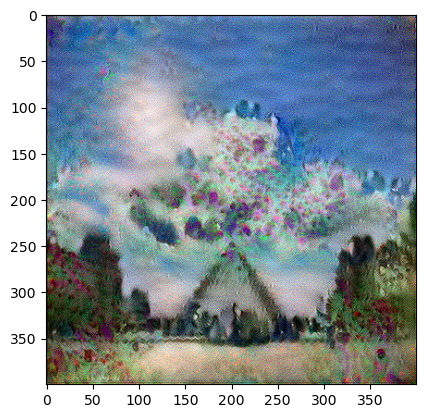

Epoch 1250 


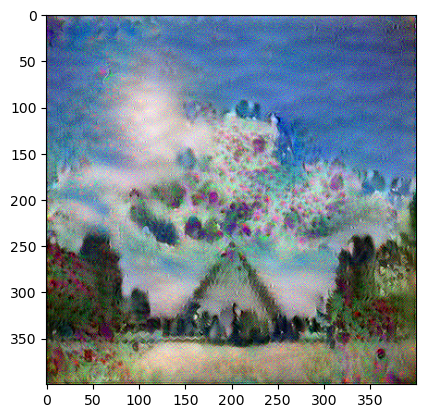

Epoch 1500 


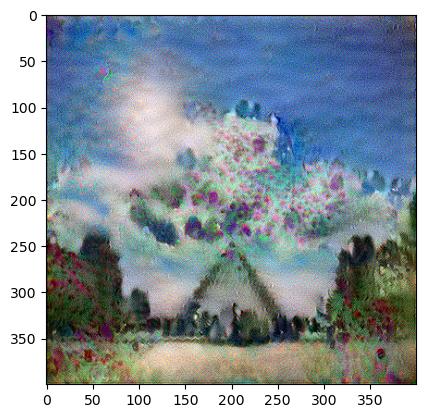

Epoch 1750 


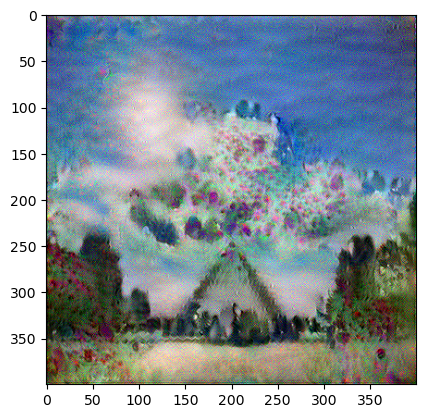

Epoch 2000 


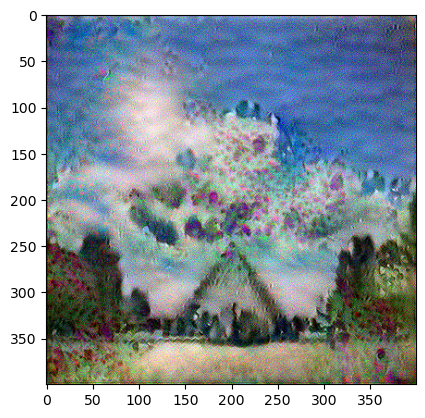

Epoch 2250 


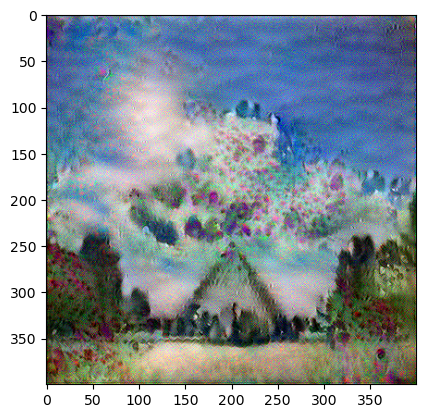

Epoch 2500 


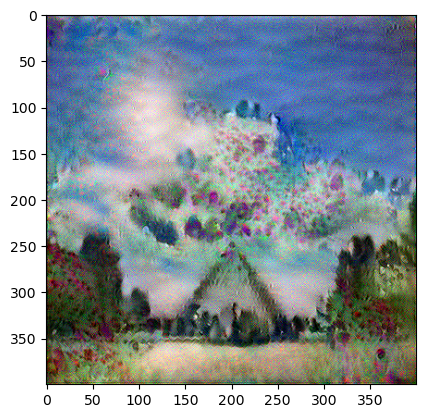

In [171]:
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"datasets/style_transfer/output/image_{i}.jpg")
        plt.show() 

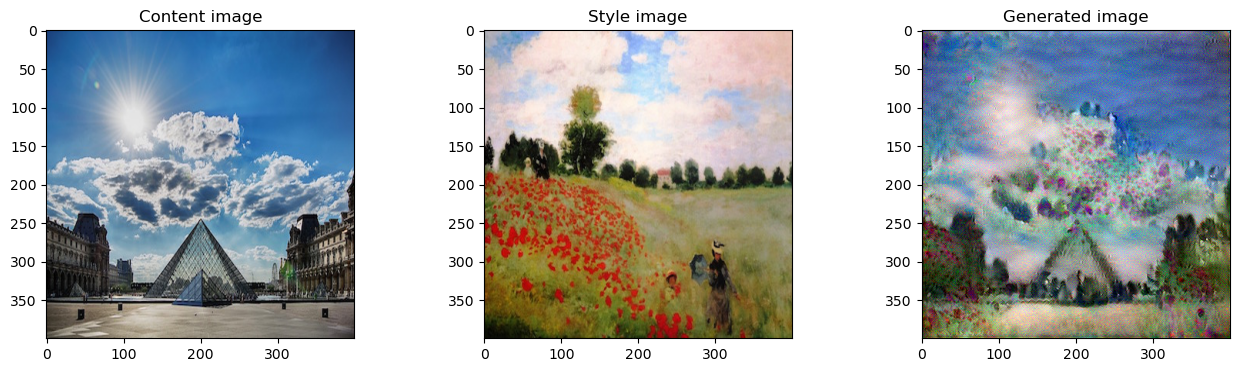

In [172]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()